In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# === 1. Load dataset ===
file_path = "Task 3 and 4_Loan_Data (2).csv"  # change path if needed
df = pd.read_csv(file_path)
K = 5  # number of buckets

In [5]:
# === 2. Aggregate by unique FICO scores ===
agg = df.groupby("fico_score").agg(
    n=("fico_score", "size"),
    defaults=("default", "sum")
).reset_index().sort_values("fico_score")

scores = agg["fico_score"].to_numpy()
counts = agg["n"].to_numpy()
defaults = agg["defaults"].to_numpy()
M = len(scores)

# Prefix sums for range statistics
pref_counts = np.concatenate([[0], np.cumsum(counts)])
pref_defaults = np.concatenate([[0], np.cumsum(defaults)])
pref_sum_scores = np.concatenate([[0], np.cumsum(scores * counts)])
pref_sumsq_scores = np.concatenate([[0], np.cumsum((scores ** 2) * counts)])


def range_stats(i, j):
    """Compute statistics for scores[i..j] inclusive."""
    n = pref_counts[j + 1] - pref_counts[i]
    k = pref_defaults[j + 1] - pref_defaults[i]
    s = pref_sum_scores[j + 1] - pref_sum_scores[i]
    ssq = pref_sumsq_scores[j + 1] - pref_sumsq_scores[i]
    return int(n), int(k), float(s), float(ssq)

In [6]:
# === 3. Define cost functions ===
def cost_mse(i, j):
    n, k, s, ssq = range_stats(i, j)
    if n == 0:
        return 0.0
    return ssq - (s * s) / n  # sum of squared errors


def cost_negloglik(i, j, eps=1e-12):
    n, k, s, ssq = range_stats(i, j)
    if n == 0:
        return 0.0
    p = k / n
    p = min(max(p, eps), 1 - eps)  # avoid log(0)
    ll = k * math.log(p) + (n - k) * math.log(1 - p)
    return -ll  # minimize negative log-likelihood

In [7]:
# === 4. Dynamic Programming for optimal partitions ===
def optimal_partition(cost_fn, K):
    dp = np.full((K + 1, M), np.inf)
    back = np.full((K + 1, M), -1, dtype=int)

    # Base case (1 segment)
    for m in range(M):
        dp[1, m] = cost_fn(0, m)
        back[1, m] = -1

    for t in range(2, K + 1):
        for m in range(t - 1, M):
            best_cost, best_s = np.inf, -1
            for s in range(t - 1, m + 1):
                prev = dp[t - 1, s - 1]
                if prev == np.inf:
                    continue
                c = prev + cost_fn(s, m)
                if c < best_cost:
                    best_cost, best_s = c, s
            dp[t, m] = best_cost
            back[t, m] = best_s

    # Reconstruct partitions
    parts = []
    t, m = K, M - 1
    while t > 0:
        s = back[t, m]
        if s == -1:
            parts.append((0, m))
            break
        parts.append((s, m))
        m = s - 1
        t -= 1
    return dp[K, M - 1], parts[::-1]

In [8]:
# === 5. Run for both objectives ===
mse_cost, mse_parts = optimal_partition(cost_mse, K)
nll_cost, nll_parts = optimal_partition(cost_negloglik, K)


def parts_to_table(parts):
    rows = []
    for (i, j) in parts:
        n, k, s, ssq = range_stats(i, j)
        mean_fico = s / n if n > 0 else np.nan
        rows.append({
            "fico_min": int(scores[i]),
            "fico_max": int(scores[j]),
            "n": n,
            "defaults": k,
            "default_rate": k / n if n > 0 else np.nan,
            "mean_fico": mean_fico
        })
    return pd.DataFrame(rows)

In [9]:
# === 6. Assign ratings ===
def assign_ratings(table):
    table = table.copy()
    order = np.argsort(-table["mean_fico"].values)
    rating = np.empty(len(table), dtype=int)
    rating[order] = np.arange(1, len(table) + 1)
    table["rating"] = rating
    table["letter"] = [chr(ord("A") + r - 1) for r in rating]
    return table.sort_values("fico_min").reset_index(drop=True)


mse_table = assign_ratings(parts_to_table(mse_parts))
nll_table = assign_ratings(parts_to_table(nll_parts))

print("\n=== MSE-based buckets ===")
print(mse_table)

print("\n=== Log-Likelihood-based buckets ===")
print(nll_table)


=== MSE-based buckets ===
   fico_min  fico_max     n  defaults  default_rate   mean_fico  rating letter
0       408       552   797       428      0.537014  522.066499       5      E
1       553       607  2240       635      0.283482  583.435268       4      D
2       608       654  3036       488      0.160738  631.461133       3      C
3       655       706  2634       242      0.091875  677.783599       2      B
4       707       850  1293        58      0.044857  734.877804       1      A

=== Log-Likelihood-based buckets ===
   fico_min  fico_max     n  defaults  default_rate   mean_fico  rating letter
0       408       520   301       199      0.661130  495.189369       5      E
1       521       580  1407       536      0.380952  557.218195       4      D
2       581       640  3438       703      0.204479  612.789122       3      C
3       641       696  3197       336      0.105099  666.358148       2      B
4       697       850  1657        77      0.046470  727.461074   

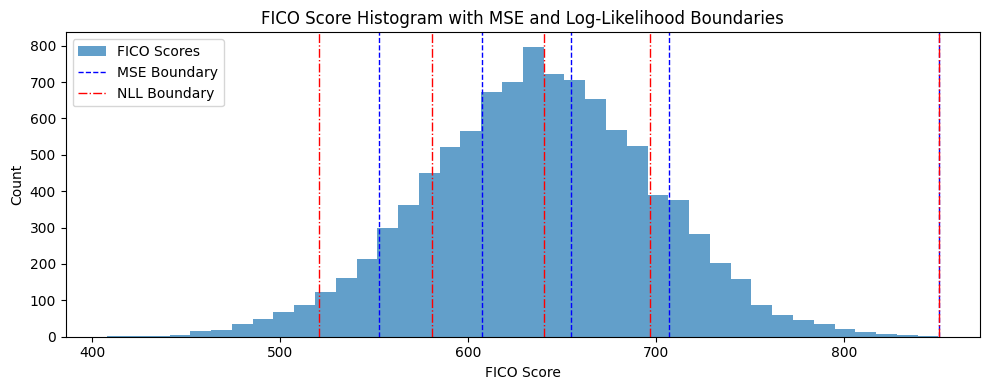

In [10]:
# === 7. Visualize ===
plt.figure(figsize=(10, 4))
plt.hist(df["fico_score"], bins=40, alpha=0.7, label="FICO Scores")
for _, row in mse_table.iterrows():
    plt.axvline(row["fico_max"] + 0.5, color="blue", linestyle="--", linewidth=1, label="MSE Boundary" if _ == 0 else "")
for _, row in nll_table.iterrows():
    plt.axvline(row["fico_max"] + 0.5, color="red", linestyle="-.", linewidth=1, label="NLL Boundary" if _ == 0 else "")
plt.title("FICO Score Histogram with MSE and Log-Likelihood Boundaries")
plt.xlabel("FICO Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()